# Borrowing of strength in Bayesian hierarchical model
We consider the problem of estimating the average number of patients admitted to
ER per day from various hospitals across a city. A Bayesian hierarchical model
(BHM) allows us to partially pool information across hospitals, reducing
variance in small-sample groups and leveraging strength across hospitals to
estimate the population-level parameters. Here, we investigate a Poisson-
lognormal model.

(a) Generate a dataset where the logarithm of the expected number of admissions
    per day for hospital $j$, $ln \lambda_j$, comes from a Normal distribution:

$$ ln \lambda_j \sim \mathcal{N}(\mu_0,\,\sigma_0^{2}), \text{ for } j = 1, ..., J $$

The admission counts data for each hospital for day $i$ follow a Poisson
distribution:

$$ y_{ij} \mid \lambda_j \sim \text{Poisson}(\lambda_j), \text{ for } i = 1, ..., n_j $$

where each hospital $j$ has a different reporting frequency, which leads to
different $n_j$ for each. To model this, you may draw $n_j$ randomly with equal
probability from the set $\{52, 24, 12\}$, representing respectively weekly,
twice a month and monthly reporting. Do this once, and keep $n_j$ fixed,
treating it as known, throughout the exercise.

The DAG for this model is shown in the figure.

![Figure 1: DAG for hospital admission BHM](./figure_1.pdf)

Since $\mu_0$ is the typical log-rate
across hospitals, we may choose for its prior
$$Pr(\mu_0) = \mathcal{N}(\log m, s^2)$$

where $m$ is a plausible choice for the median number of admissions/day, and s
controls its spread. Since $\sigma_0$ controls the variability across hospitals,
a prior choice that tends to reinforce shrinkage is $Pr(\sigma_0) = \exp(\tau)$.

Fix $m$, $s^2$, $\tau$ to sensible values, and use an MCMC algorithm of your
choice to sample from the model and produce posterior distribution on
$\{\lambda_j\}^J_{j=1}, \mu _0, \sigma _0$ (a sensible choice might be $J = 10$
hospitals).

____

(b) Determine the marginal posterior distribution for the admission rate for
each hospital, and compare it with the posterior estimate in a model with no
pooling (i.e., where each hospital’s rate is inferred exclusively from its
observed counts, i.e. $\ln \lambda_j \sim \mathcal{N} (\mu_0, \sigma^2_0)$ and
the same priors as above, and the posterior for hospital j comes exclusively
from its own data). Check that the posterior means for hospitals with a smaller
number of records (i.e., $n_j = 12$) exhibit stronger shrinkage towards the
global mean, thus demonstrating borrowing of strength, and typically have 68%
HPD credible intervals that are shorter than in the pooling model. You may use a
violin plot to make this comparison.

___

(c) Consider the prior predictive distribution for possible data within the BHM:

$$ Pr( y_{ij} \mid priors) = \int Pr ( y_{ij} \mid \lambda_j) Pr(\lambda_j \mid \mu_0, \sigma_0) Pr (\mu_0,\sigma_0) d \mu_0 d \sigma_0$$

and simulate from it predictions for the possible counts $y_{ij}$ from the model
(before you see any data). Evaluate the degree of shrinkage by using as metric
the average shrinkage in the standard deviation of the posterior with respect to
the no-pooling scenario, i.e.

$$ S = \frac {1} {J} \sum_{j=1}^{J}{1 - \frac{\text{std}_\text{BHM}(\ln \lambda_j \mid \bold y)}{\text{std}_\text{no pool}(\ln \lambda_j \mid \bold y)}}$$

where a smaller S corresponds to higher degree of shrinkage.

Determine which hyperparameter among $(m, s, \tau)$ has the most effect on the
degree of shrinkage, and tune each to avoid predictions that are too diffuse
(i.e., the predictive spread is unreasonably wide) or too narrow (i.e., the
predictive spread is over-constraining).

In [ ]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.stats import pearsonr

np.random.seed(42)

In [2]:
J = 10
reporting_frequency = np.random.choice(
    [54, 24, 12],
    J
)

print(f"We have {J} hospitals reporting admission data.")
for j in range(J):
    print(
        f"- Hospital number {j + 1:2} reports admission data "
        f"{reporting_frequency[j]} times a year."
    )

We have 10 hospitals reporting admission data.
- Hospital number  1 reports admission data 12 times a year.
- Hospital number  2 reports admission data 54 times a year.
- Hospital number  3 reports admission data 12 times a year.
- Hospital number  4 reports admission data 12 times a year.
- Hospital number  5 reports admission data 54 times a year.
- Hospital number  6 reports admission data 54 times a year.
- Hospital number  7 reports admission data 12 times a year.
- Hospital number  8 reports admission data 24 times a year.
- Hospital number  9 reports admission data 12 times a year.
- Hospital number 10 reports admission data 12 times a year.


In [3]:
true_lambdas = []

def get_expected_admission_counts(mu: float, sigma: float, size: int):
    """Get expected number of admissions to a hospital at 'size' time points.
    
    The log of the admission rate comes from a normal distribution with mean
        'mu' and standard deviation 'sigma'.
    The expected number of admissions comes from a Poisson distribution with
        parameter 'admission_rate'.
    From the same Poisson distribution, 'size' time points will be sampled.
    """
    log_admission_rate = np.random.normal(
        mu, sigma
    )
    admission_rate = np.exp(log_admission_rate)
    true_lambdas.append(admission_rate)
    admission_counts = np.random.poisson(
        admission_rate, size=size
    )
    return admission_counts

In [4]:
def get_admission_count_matrix(mu: float, sigma: float) -> pd.DataFrame:
    data = {}
    total_array_length = max(reporting_frequency)
    for j in range(J):  # For each hospital
        data_array_length = reporting_frequency[j]
        admission_records = get_expected_admission_counts(
            mu, sigma, size=data_array_length
        )
        padding = np.full(total_array_length - data_array_length, 0, dtype=int)
        admission_records = np.concatenate([
            admission_records,
            padding
        ])
        data[f"Hospital {j+1}"] = admission_records
    data = pd.DataFrame(data)
    data.index.name = "Time point"
    return data.transpose()

- Prior for $\mu_0$: we choose $m$ (typical log-rate across hospitals) and $s$
(a measure of the spread of $m$); $Pr(\mu_0) = \mathcal{N}(\log m, s^2)$.
- Prior for $\sigma_0$: $Pr(\sigma_0) = \text{Exponential}(\tau)$

In [5]:
m = 85
s = 0.4
tau = 0.1

In [6]:
true_mu_0 = np.random.normal(np.log(m), s)
true_sigma_0 = np.random.exponential(tau)

df = get_admission_count_matrix(mu=true_mu_0, sigma=true_sigma_0)

print(df)

Time point    0    1    2    3    4    5    6    7    8    9   ...   44   45  \
Hospital 1   149  147  161  152  144  155  171  161  146  173  ...    0    0   
Hospital 2   180  166  160  178  182  147  153  151  154  161  ...  150  152   
Hospital 3   174  147  163  149  146  156  144  142  177  166  ...    0    0   
Hospital 4   154  178  170  138  178  165  145  167  148  149  ...    0    0   
Hospital 5   163  155  156  165  160  160  169  155  183  175  ...  143  168   
Hospital 6   163  162  165  161  156  180  136  167  153  151  ...  142  165   
Hospital 7   167  165  179  178  164  147  154  161  173  146  ...    0    0   
Hospital 8   145  155  174  159  151  176  162  150  164  166  ...    0    0   
Hospital 9   183  150  153  150  143  145  165  154  159  146  ...    0    0   
Hospital 10  154  167  171  138  181  151  169  148  159  154  ...    0    0   

Time point    46   47   48   49   50   51   52   53  
Hospital 1     0    0    0    0    0    0    0    0  
Hospital 2 

We can use AIES (ensemble samplers with affine invariance), introduced by
Goodman and Weare in 2010 and implemented by the `emcee` python package, to
sample from the joint posterior without analytically deriving it.

We have to write a function that takes in all hyper-parameters (both fixed and
unknown) and returns the posterior value for those parameters; we will then
construct an `emcee.EnsembleSampler` (giving the number of unknown parameters
and the known ones) and we will finally run MCMC for a certain number of steps.
The sampler will return tuples of sampled parameters.

For analytical convenience, we will use $\ln(Posterior)$, $\ln(\text{Prior})$
and $\ln(\mathcal{L})$.

In [7]:
j=6
type(df.iloc[j,:reporting_frequency[j]])

pandas.core.series.Series

In [ ]:
def log_posterior(parameters, m: float, s: float, tau: float, J: int):
    # lambda_j is an array of length J with the admission rate for each hospital
    mu_0, sigma_0, *lambdas = parameters
    # Check parameters that have to be strictly positive
    if sigma_0 <= 0:  # Standard deviation of a Normal distribution
        return -np.inf
    if any(l <= 0 for l in lambdas):  # Frequency of a Poisson distribution
        return -np.inf
    log_prior = 0.0
    # Prior for 'mu_0' (normally distributed, parameters 'm' and 's')
    log_prior += (
        -0.5 * np.log(2 * np.pi * s**2)
        -0.5 * ((mu_0 - np.log(m))**2) / s**2
    )
    # Prior for 'sigma_0' (exponentially distributed, parameter 'tau')
    log_prior += (
         np.log(tau) - tau * sigma_0
    )
    log_likelihood = 0.0
    # Prior for 'lambdas' (each log-normally distributed, parameters 'mu_0', 'sigma_0')
    # and likelihood of 'observed_admissions' (Poisson distributed, parameter 'lambdas[j]')
    # We only iterate once over range(J) for the sake of efficiency
    for j in range(J):
        log_prior += (
            -np.log(lambdas[j] * sigma_0 * np.sqrt(2 * np.pi))
            - ((np.log(lambdas[j]) - mu_0)**2) / (2 * sigma_0**2)
        )
        # Get the observed admission counts for hospital j,
        #   and cast it to a numpy array for efficiency
        # This is equivalent to (but faster than) a for loop
        #   for i in range(reporting_frequency[j]):
        #       reporting_frequency = df.iloc[j, i]
        #       log_likelihood += (...)
        observed_admissions = df.iloc[j,:reporting_frequency[j]].to_numpy()
        log_likelihood += np.sum(
            observed_admissions * np.log(lambdas[j])
            - lambdas[j]
            - gammaln(observed_admissions+1)
        )
    return log_prior + log_likelihood

In [9]:
# Data: observed_admissions (from previous synthetic data generation)
# Assuming observed_admissions is a pandas df (J * max(reporting_frequency))

# Number of dimensions and walkers
ndim = 2 + J  # [mu_0, sigma_0, lambda_1, ..., lambda_J]
num_walkers = 32

# Initial guess for parameters
initial_guess = [
      true_mu_0,
      true_sigma_0,
      *true_lambdas
]

# Initialize walkers in a small ball around the initial guess
pos = initial_guess + 1e-4 * np.random.randn(num_walkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(
      num_walkers, ndim, log_posterior,
      args=(m, s, tau, J)
)

# Run MCMC
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get one sample every 'thin' steps, discarding the burn-in (first 'discard' steps)
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

100%|██████████| 5000/5000 [03:36<00:00, 23.12it/s]


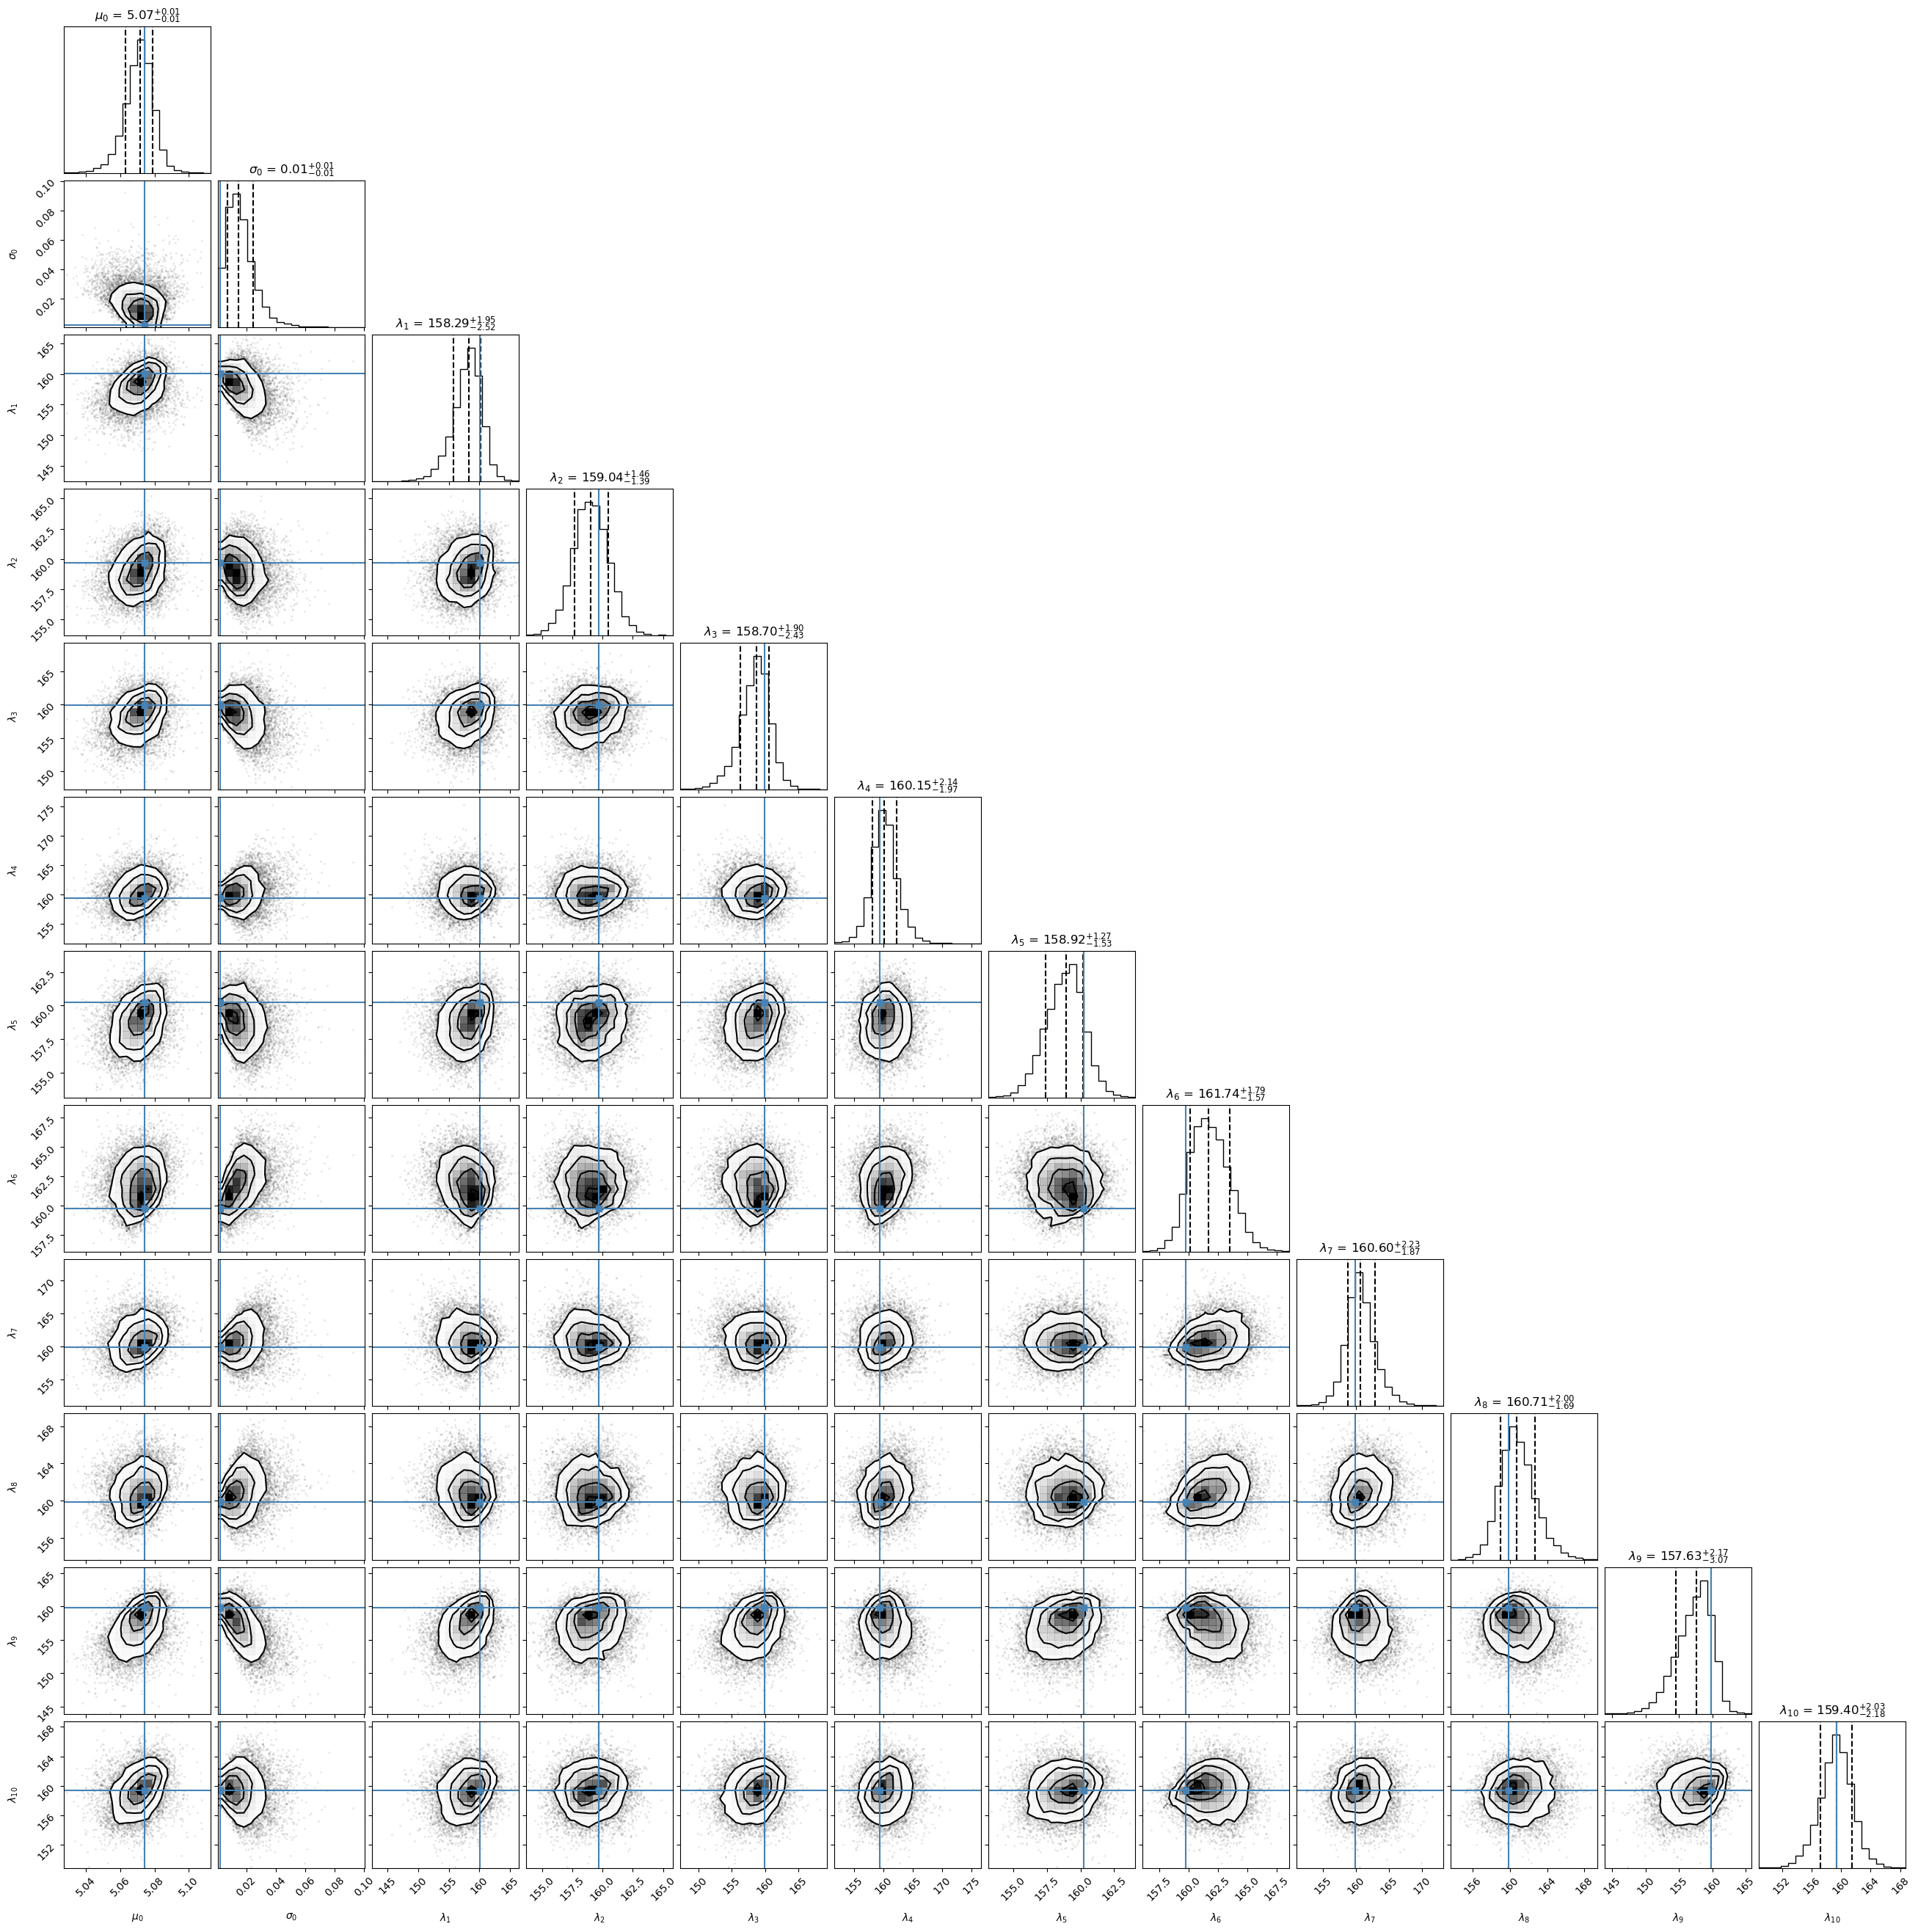

In [10]:
# Labels and true values
labels = [r'$\mu_0$', r'$\sigma_0$', *[rf'$\lambda_{{{j + 1}}}$' for j in range(J)]]
truths = [true_mu_0, true_sigma_0, *true_lambdas]

# Create a corner plot
fig = corner.corner(
    samples,
    labels=labels,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)
plt.show()

### (b) Here are the marginal posterior distributions of admission rates for every hospital:

In [23]:
rows = []

for j in range(J):
    mu_0_j = samples[:, 0]
    sigma_0_j = samples[:, 1]
    lambda_samples_j = samples[:, 2 + j]
    lower, upper = np.percentile(lambda_samples_j, [16, 84])
    rows.append({
        "Hospital": j + 1,
        "Reporting frequency": reporting_frequency[j],
        "16th percentile": lower,
        "84th percentile": upper,
        "HPD width (68%)": upper - lower,
        "mu_0": np.mean(mu_0_j),
        "sigma_0": np.mean(sigma_0_j)
    })

temp = pd.DataFrame(rows)
temp = pd.DataFrame(rows).set_index("Hospital")
print(temp)


          Reporting frequency  16th percentile  84th percentile  \
Hospital                                                          
1                          12       155.772971       160.241098   
2                          54       157.656116       160.502618   
3                          12       156.272260       160.602153   
4                          12       158.177209       162.292523   
5                          54       157.382752       160.187262   
6                          54       160.169699       163.533840   
7                          12       158.731447       162.830338   
8                          24       159.015641       162.708823   
9                          12       154.559953       159.806722   
10                         12       157.219515       161.435273   

          HPD width (68%)      mu_0   sigma_0  
Hospital                                       
1                4.468127  5.070992  0.016259  
2                2.846502  5.070992  0.016259  
3  

In [ ]:
x = temp["Reporting frequency"].to_numpy()
y = temp["HPD width (68%)"].to_numpy()

r, p_value = pearsonr(x, y)
r_squared = r**2

print(f"Pearson r = {r:.3f}")
print(f"R^2 = {r_squared:.3f}")
print(f"p-value = {p_value:.3e}")


Pearson r = -0.874
R^2 = 0.764
p-value = 9.495e-04


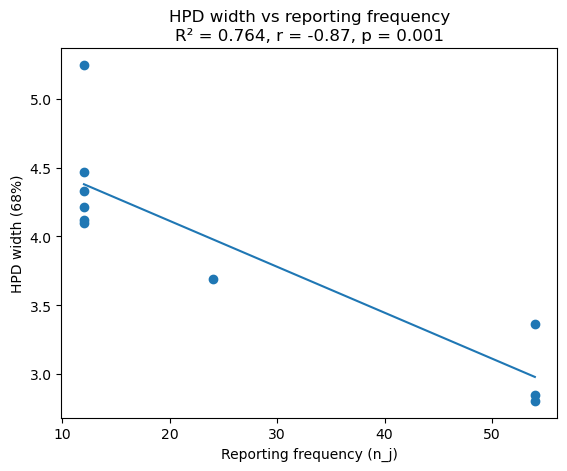

In [29]:
# Fit least-squares line
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

plt.figure()
plt.scatter(x, y)
plt.plot(x_line, y_line)
plt.xlabel("Reporting frequency (n_j)")
plt.ylabel("HPD width (68%)")
plt.title(
    f"HPD width vs reporting frequency\n"
    f"R² = {r_squared:.3f}, r = {r:.2f}, p = {p_value:.3f}"
)
plt.show()
